# KNN

In [376]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, classification_report

import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import confusion_matrix

import os
os.environ['OMP_NUM_THREADS'] = '1'

In [358]:
trees = pd.read_csv('../categorized_data.csv')
len(trees)
trees['season'] = pd.cut(trees['mo'], bins=[-0.5, 3.5, 6.5, 9.5, 12.5], labels=['winter', 'spring', 'summer', 'fall'])
trees['mo_cos'] = np.cos(2 * np.pi * trees['mo'] / 12)
trees['mo_sin'] = np.sin(2 * np.pi * trees['mo'] / 12)

trees['growth_2'] = pd.cut(trees['change_basal_area'], bins=[-0.5, 0.07, 0.16, 1000], labels=['No/Little Growth', 'Moderate Growth', 'Extreme Growth'])
trees['growth_2'] = pd.qcut(trees['change_basal_area'], 3, labels=['No/Little Growth', 'Moderate Growth', 'Extreme Growth'])
trees['growth_category'] = trees['growth_category'].replace({'No Growth': 'A Little Growth'})

trees['growth_pct'] = trees['change_basal_area'] / (trees['average_basal_area'] - trees['change_basal_area'])
trees['growth_pct_cat'] = pd.qcut(trees['growth_pct'], 4, labels=['No/Little Growth', 'Moderate Growth', 'Moderate Growth2', 'Extreme Growth'])
trees['growth_pct_cat'] = trees['growth_pct_cat'].replace({'Moderate Growth2': 'Moderate Growth'})
trees['growth_pct_cat2'] = pd.qcut(trees['growth_pct'], 3, labels=['No/Little Growth', 'Moderate Growth', 'Extreme Growth'])
trees.head().T

C:\Users\seths\AppData\Local\Temp\ipykernel_13112\620401679.py:13: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



,0,1,2,3,4
Unnamed: 0,1,2,4,5,7
site,AK,AK,AK,AK,AK
tree,1A,1A,1A,1A,1A
plot,1,1,1,1,1
species,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-01-01,2019-02-01,2019-05-01,2019-06-01,2018-07-01
longitude,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571
latitude,68.018576,68.018576,68.018576,68.018576,68.018576
da,1,1,1,1,1
mo,1,2,5,6,7


### Model Selection

In [367]:
target_col = 'growth_2'
cat_cols = ['species']
num_cols = [
    'average_air_temperature', 
    'average_air_pressure',
    'average_humidity',
    'avg_solar_irradiance', 
    'avg_soil_water_content',
    'average_stem_radius'
]

y = trees[target_col]
X = trees[cat_cols + num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [368]:
y.value_counts(normalize=True)

growth_2
No/Little Growth    0.333358
Extreme Growth      0.333358
Moderate Growth     0.333284
Name: proportion, dtype: float64

In [369]:
preprocess = ColumnTransformer(
    transformers=[
        ('num - scaler', StandardScaler(), num_cols),
        ('cat - ordinal', OrdinalEncoder(), cat_cols)
    ]
)

pipe = Pipeline([
    ('preprocessor', preprocess),
    ('knn', KNeighborsClassifier(weights='distance'))
])


In [ ]:
param_grid = {'knn__n_neighbors': range(1, 100, 2)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid.fit(X_train, y_train)


,estimator,Pipeline(step...'distance'))])
,param_grid,"{'knn__n_neighbors': range(1, 150, 2)}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num - scaler', ...), ('cat - ordinal', ...)]"


In [371]:
results_df = pd.DataFrame(grid.cv_results_)

results_df['k'] = results_df['param_knn__n_neighbors']
results_df['mean_score'] = results_df['mean_test_score']

best_k = grid.best_params_['knn__n_neighbors']
best_score = grid.best_score_
print('best K:', best_k, '\nbest score:', best_score)

fig = px.line(
    results_df,
    x='k',
    y='mean_score',
    title=f'Cross-Validated Balanced Accuracy vs. K (best k = {best_k})',
    markers=True,
    labels={'k': 'Number of Neighbors (k)', 'mean_score': 'Mean CV Balanced Accuracy'}
)


fig.add_scatter(
    x=[best_k],
    y=[best_score],
    mode='markers+text',
    text=[f'Best k = {best_k}'],
    textposition='top center',
    name='Best k'
)

fig.update_layout(hovermode='x unified')
fig.show()

best K: 29 
best score: 0.6615543328748281


### Final Model

In [375]:
knn_final = Pipeline([
    ('preprocessor', preprocess),
    ('knn', KNeighborsClassifier(n_neighbors=best_k, weights='distance'))
])

knn_final.fit(X_train, y_train)
y_pred = knn_final.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
recalls = recall_score(y_test, y_pred, average=None)

print(f'Accuracy: {acc:.3f}')
print(f'Balanced accuracy: {bal_acc:.3f}')
print(f"Per-class recalls: {[float(f"{x:.4f}") for x in recalls]}")

Accuracy: 0.671
Balanced accuracy: 0.671
Per-class recalls: [0.7626, 0.5171, 0.7327]


{'Extreme Growth': {'precision': 0.7154639175257732, 'recall': 0.7626373626373626, 'f1-score': 0.7382978723404255, 'support': 910.0}, 'Moderate Growth': {'precision': 0.5956907477820025, 'recall': 0.517051705170517, 'f1-score': 0.5535924617196702, 'support': 909.0}, 'No/Little Growth': {'precision': 0.6873065015479877, 'recall': 0.7326732673267327, 'f1-score': 0.7092651757188498, 'support': 909.0}, 'accuracy': 0.6708211143695014, 'macro avg': {'precision': 0.6661537222852544, 'recall': 0.6707874450448706, 'f1-score': 0.6670518365929818, 'support': 2728.0}, 'weighted avg': {'precision': 0.66617179787002, 'recall': 0.6708211143695014, 'f1-score': 0.6670779531750007, 'support': 2728.0}}


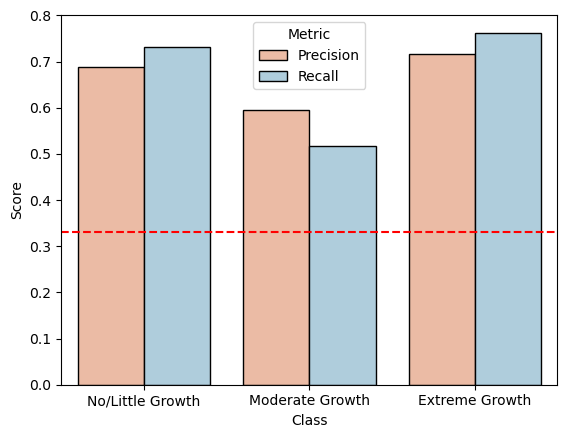

In [374]:
report_dict = classification_report(y_test, y_pred, output_dict=True)

classes_to_plot = ['No/Little Growth', 'Moderate Growth', 'Extreme Growth']
perf_data = {
    'Class': classes_to_plot,
    'Precision': [report_dict[c]['precision'] for c in classes_to_plot],
    'Recall':    [report_dict[c]['recall'] for c in classes_to_plot]
}
df_perf = pd.DataFrame(perf_data)
df_perf_melted = df_perf.melt(id_vars='Class', var_name='Metric', value_name='Score')

sns.barplot(
    x='Class', 
    y='Score', 
    hue='Metric', 
    data=df_perf_melted, 
    palette='RdBu', 
    edgecolor='black'
).axhline(0.33, color='red', linestyle='--', label='Random Chance (0.33)')
print(report_dict)

In [380]:

labels = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Text annotations
text = [[str(cm[i][j]) for j in range(len(labels))] for i in range(len(labels))]

fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=labels,
    y=labels,
    colorscale="Blues",
    showscale=True,
    text=text,
    texttemplate="%{text}",
    hovertemplate="Actual: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>"
))

fig.update_layout(
    title="Confusion Matrix",
    xaxis=dict(title="Predicted Label", side="top"),
    yaxis=dict(title="Actual Label", autorange="reversed"),
    template="plotly_white",
    height=600,
    width=600
)

In [381]:
list(trees[target_col].unique())

['Moderate Growth', 'No/Little Growth', 'Extreme Growth']

### Testing

In [271]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 10000

# Create true labels (3 classes)
# You can make this balanced or imbalanced
true_labels = trees[target_col].values

# Create random predictions (uniform distribution across 3 classes)
choices_1 = ['No Growth', 'A Little Growth', 'A Lot of Growth']
p = [0.062844, 0.463665, 0.473491]
choices_2 = ['No/Little Growth', 'Moderate Growth', 'Extreme Growth']
random_predictions = np.random.choice(choices_2, size=len(true_labels))

# Calculate balanced accuracy
bal_acc = balanced_accuracy_score(true_labels, random_predictions)
acc = accuracy_score(true_labels, random_predictions)

print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Expected: ~0.3333")

print(f"accuracy: {acc:.4f}")

# Let's also check per-class recall to see how balanced accuracy is calculated
from sklearn.metrics import recall_score

recalls = recall_score(true_labels, random_predictions, average=None)
print(f"\nPer-class recalls: {recalls}")
print(f"Average of recalls: {np.mean(recalls):.4f}")

Balanced Accuracy: 0.3310
Expected: ~0.3333
accuracy: 0.3309

Per-class recalls: [0.32547479 0.33141395 0.33615755]
Average of recalls: 0.3310
